In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
import random
import pymc3 as pm
import exoplanet as xo
import pickle
import pandas as pd

import caustic as ca

random.seed(42)

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

# Print library version numbers
print("Numpy version", np.__version__)
print("PyMC3 version", pm.__version__)

%config InlineBackend.figure_format = 'retina'

Numpy version 1.13.3
PyMC3 version 3.7


# Load traces of all fitted events into memory

In [17]:
def load_samples(data_path, param_name):
    param_samples = []
    logp_param_samples = []
    
    for directory in os.listdir(data_path):
        # Load trace
        path = data_path + directory 
        try:
            trace = pd.read_csv(path + '/PSPL_hmc/trace.csv')
            param_samples.append(trace[param_name].values)
            logp_param_samples.append(trace['logp_' + param_name].values)
        except:
            pass
        
    return param_samples, logp_param_samples

samples, logp_samples = load_samples('../output/2017/', 'ln_Delta_F__0')

In [18]:
medians = []
medians_logp = []

for s in samples:
    medians.append(np.median(s))
    
for s in logp_samples:
    medians_logp.append(np.median(s))

Text(0.5, 0, 'median $t_\\mathrm{eff}$')

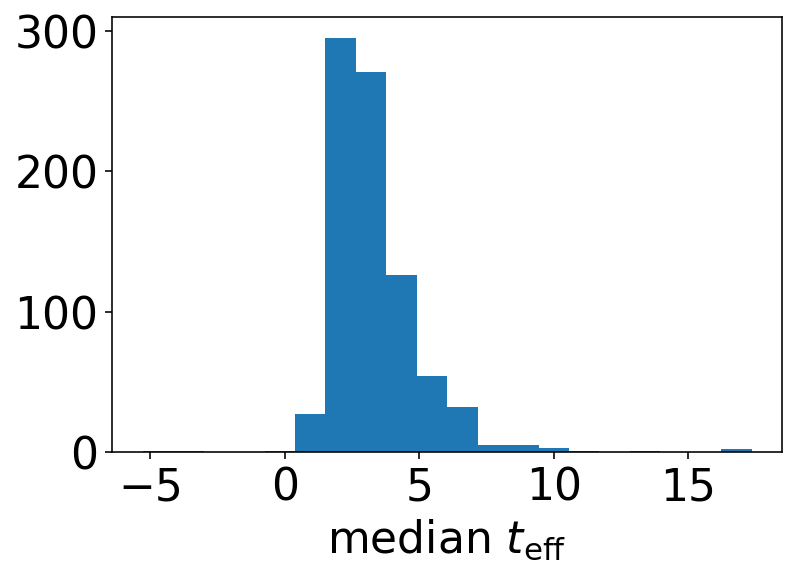

In [19]:
# Plot histograms 

fig, ax = plt.subplots()

ax.hist(medians, bins=20);
ax.set_xlabel('median $t_\mathrm{eff}$')

# Fit hierarhical model using importance resampling

In [20]:
def lognormal_prior(x, params):
    """
    Log normal prior.
    """
    mu, sig = params
    
    return np.exp(-0.5*(np.log(x) - mu)**2/sig**2)/(x*sig*np.sqrt(2*np.pi)) 


def normal_prior(x, params):
    """
    Normal prior.
    """
    mu, sig = params
    
    return scipy.stats.norm.pdf(x, mu, sig)


def log_likelihood(params, samples_w, samples_p_w): 
    """
    Computes the approximate likelihood :math:`p(\theta|\{F_k\})` for
    hyperparameters :math:`\theta` and a population of datasets :math:`\{F_k\}` 
    assuming we have posterior samples for each dataset individually.
    
    Args
    ----
    samples_w : list of ndarays
        Posterior samples for the parameters of interest.
    samples_p_w: list of ndarrays
        Values of the original prior evaluated at posterior samples.
        
    Returns
    -------
    float
        Approximate log-likelihood computed using importance re-sampled prior.
    
    """
    n_events = len(samples_w)
    
    if len(samples_w)!=len(samples_p_w):
        raise ValueError("Dimensions of the two lists of samples don't match")
                
    result = 0
        
    # Iterate over members of the population
    for i in range(n_events):
        n_samples = len(samples_w[i])
                         
        # Compute importance resampling fraction
        frac = normal_prior(samples_w[i], params)/samples_p_w[i]
        
        result += np.log(np.sum(frac)/float(n_samples)) 
        
    if np.isnan(result):
        return -np.inf    
    
    return result          

In [21]:
import scipy
def log_prior(params):
    """
    Log of hyperprior for population level parameters.
    """
    mu, sig = params
    
    logp_mu = np.log(scipy.stats.norm.pdf(mu, 5, 20.))
    logp_sig = np.log(scipy.stats.norm.pdf(sig, 5., 20.))
        
    return logp_mu + logp_sig

def log_posterior(params, samples_w, samples_p_w):
    """
    Compute log-posterior over hyperparameters.
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, samples_w, samples_p_w)

In [22]:
log_likelihood([2., 5.], samples, np.exp(logp_samples))

521.05345363829235

In [23]:
%timeit log_likelihood([2., 5.], samples, np.exp(logp_samples))

331 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
ndim, nwalkers = 2, 50

pos = [[20., 2.] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(samples, np.exp(logp_samples)))

In [25]:
sampler.run_mcmc(pos, 500)

State([[ 3.23377972  1.42888266]
 [ 3.33794837  1.50060815]
 [ 3.24120445  1.40076385]
 [ 3.27775466  1.42699947]
 [ 3.26078119  1.45707706]
 [ 3.22477628  1.44171224]
 [ 3.22234784  1.46021745]
 [ 3.19848665  1.42429855]
 [ 3.27309048  1.39595724]
 [ 3.21421379  1.41033242]
 [ 3.15666738  1.42582138]
 [ 3.28498607  1.4477971 ]
 [ 3.22630707  1.4751352 ]
 [ 3.21359836  1.41729478]
 [ 3.3262647   1.39042925]
 [ 3.2222098   1.47697195]
 [ 3.1834271   1.43944739]
 [ 3.22172799  1.37416789]
 [ 3.30504571  1.43501766]
 [ 3.24428699  1.41642812]
 [ 3.25236991  1.40039896]
 [ 3.18641047  1.40961276]
 [ 3.24617279  1.43290114]
 [ 3.27800737  1.4471544 ]
 [ 3.28367339  1.38402601]
 [ 3.22076621  1.41852699]
 [ 3.30771513  1.42143033]
 [ 3.38613336  1.42460269]
 [ 3.27138392  1.43004572]
 [ 3.30368336  1.41062904]
 [ 3.25529819  1.43204864]
 [ 3.26273548  1.47064928]
 [ 3.26359875  1.40959671]
 [ 3.17437502  1.46342229]
 [ 3.27472589  1.41086539]
 [ 3.31336588  1.40506346]
 [ 3.22992851  1.44149

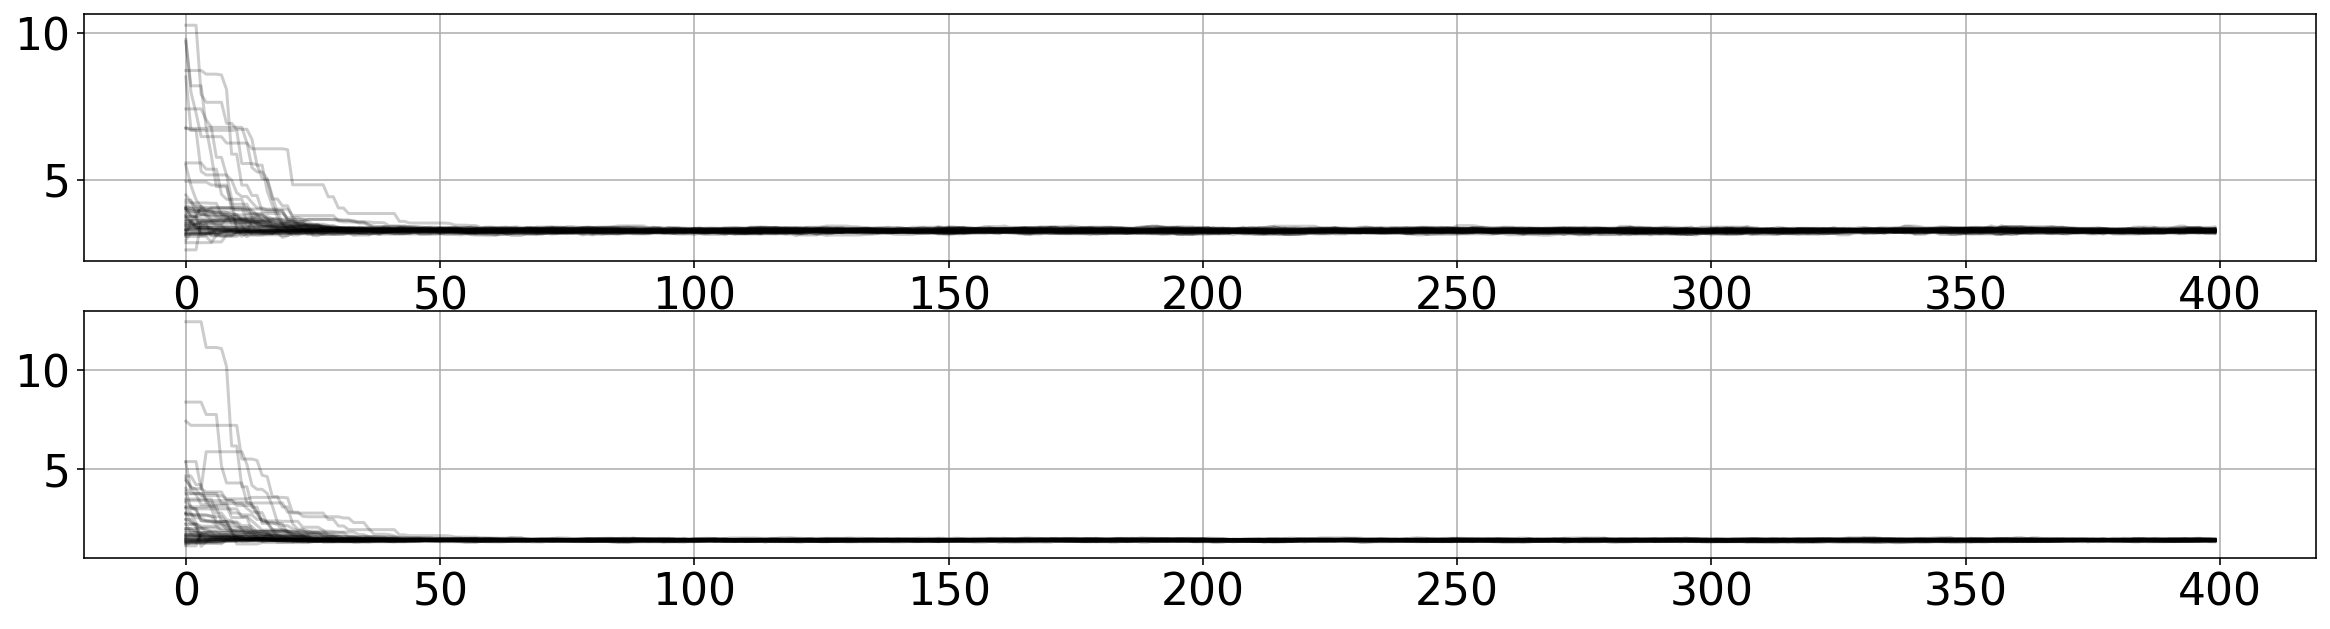

In [28]:
# Plot traceplots
fig, ax = plt.subplots(ndim, 1, figsize=(20, 5))

for i in range(ndim):
    mask = sampler.acceptance_fraction > .0
    ax[i].plot(sampler.chain[mask, 100:, i].T, 'k-', alpha=0.2);
    ax[i].grid()

(-10, 20)

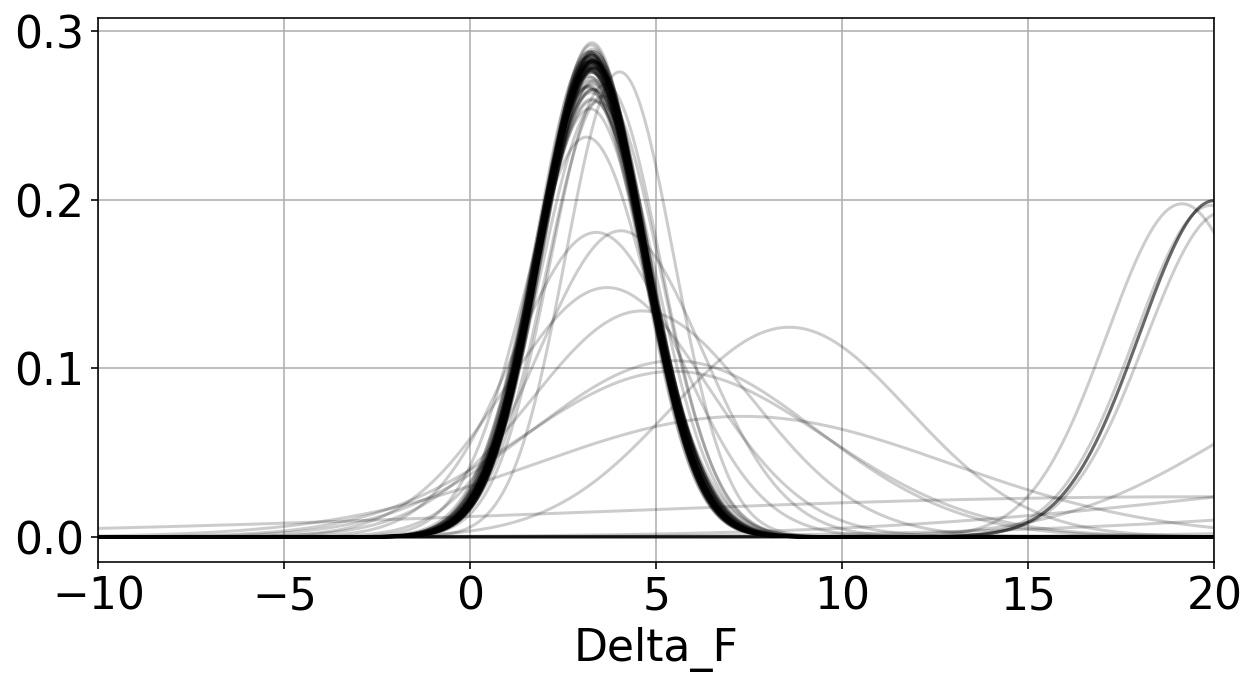

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-10, 50., 5000)
samples_hyper = sampler.flatchain[400:, :]

for mu, sig in samples_hyper[np.random.randint(len(samples_hyper), size=100)]:
    ax.plot(x, normal_prior(x, (mu, sig)), color='black', alpha=0.2)

ax.grid()
ax.set_xlabel('Delta_F')
ax.set_xlim(-10, 20)
# ax.set_ylim(0, 0.5)

# Same, but with a histogram prior